<a href="https://colab.research.google.com/github/Bobobert/RL_notebooks/blob/main/DRL_bias_variance_gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias-Variance Estudio en un gridWorld
*por Roberto-E López-Díaz*

## Métodos Libres de Modelo (Model-Free)

A continuación, comenzaremos a implementar algunas funciones para los algoritmos mencionados en clase para aproximar y predecir la función de valor aun cuando no tenemos disponible como tal un modelo. 

In [ ]:
!pip install gif
!git clone https://github.com/Bobobert/RL_Toy
!pip install /content/RL_Toy/

**Para Colab es necesario reiniciar el entorno después de ejecutar la celda de arriba**

In [11]:
# Importar librerias
import matplotlib.pyplot as plt
import numpy as np
from RL_Toy.envs import stochasticGridWorld
from RL_Toy.base import Policy, Environment, ActionSpace
from RL_Toy.policies import gridPolicy, gridPolicyEpsilon

Creamos un nuevo entorno del mundo reticula.

In [4]:
env = stochasticGridWorld(7,7, (1,1), (5,5), "8C", 100)
env.addObstacles((0,0), (1,2), (
    3,3), (4,4), (4,3), (4,5))
env.addVortex((0, 3, 0.3), (4, 2, 0.4), (3, 4, 0.7))

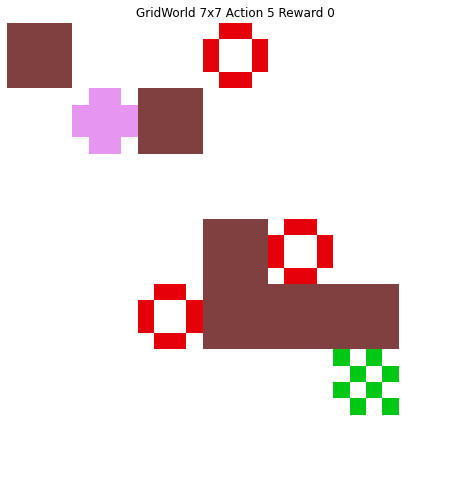

In [5]:
env.reset()
env.render()

Objeto para seguir una media y varizan de las actualizaciones 

In [6]:
# http://www.johndcook.com/blog/standard_deviation/
# https://github.com/joschu/modular_rl/blob/master/modular_rl/running_stat.py 
class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)
    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM)/self._n
            self._S[...] = self._S + (x - oldM)*(x - self._M)
    @property
    def n(self):
        return self._n
    @property
    def mean(self):
        return self._M
    @property
    def var(self):
        return self._S/(self._n - 1) if self._n > 1 else np.square(self._M)
    @property
    def std(self):
        return np.sqrt(self.var)
    @property
    def shape(self):
        return self._M.shape

## Algoritmo de Policy Evaluation

In [7]:
def policyEvaluation(env:Environment, policy:Policy, k:int, 
                     thres:float = 0.01, gamma:float = 0.99, v_init = None):
    
    """
    Policy evaluation algorithm in-place

    parameters
    ----------
    env: Environment object
        The environment object we are deling with. This funciton is design 
        for the RL_Toy kind of environment
    policy: Policy object
        The policy to evaluate. As the environmen object this is expected
        to be a RL_Toy policy type.
    k: integer > 0
        Times to iterate the algorithm
    thres: float > 0
        The threshold of the presition for the approximation. As soon the maximum
        difference is lower than the threshold the algorithm is stopped.
    gamma: float [0,1]
        The discount factor we want for the problem's return
    v_init: np.ndarray
        An initial conditions for the value function. If None give, it creates
        a new one filled with zeros

    returns
    ------- 
    V: np.ndarray
        An array with the corresponding approximation value of V for each
        cell state
    """

    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert k > 0, "k needs to be am integer greater or equal to 1 iteration."

    # Initialization
    V = np.zeros(env.shape, dtype=np.float32) if v_init is None else v_init
    states = env.observationSpace
    actions, action_n = env.actionSpace, 1 / env.actionSpace.n
    diff = 0
    policy.greedy = True
    epsilon = policy.epsilon
    epsilonA = epsilon * action_n

    # Policy evaluation

    ## Iteration as second stop condition
    for _ in range(k):
        # Iterate the states of the environment
        for state in states:
            old_V = V[state]
            # Check if the state is terminal
            if env.isTerminal(state):
                V[state] = 0
                continue # With this the next code is not not executed
            # Get the action from the policy
            g_action = policy.getAction(state)
            mean = 0
            for action in actions:
                p_a = epsilonA if action != g_action else epsilonA + (1 - epsilon)
            # Get the probabilities and next states corresponding to the
            # actual state and action
                probs, nextStates = env.transProb({"agent":state}, action)
                sum = 0
                for p, s in zip(probs, nextStates):
                    r = env.calculateReward({"agent":s})
                    sum += p * (r + gamma * V[s]) # Modification, runs in-place now
                mean += sum * p_a
            # Update the value function given pi
            V[state] = mean
            diff = max(diff, old_V - mean)
        ## First Stop condition
        if diff < thres:
            print("Stopped by precission")
            return V
    return V

## n-step TD

La siguiente es una implementación del algoritmo para generalizar entre TD0 y MC respecto al número de recompensas inmediatas utiliza para formar su actualización.

In [8]:
def nTD(env:Environment, policy:Policy, n:int, alpha:float, 
       k:int = 10, gamma:float = 0.99, epsilon:float = 0.1, v_init = None):
    
    """
    TD 0 state-value function approximation
    
    parameters
    ----------
    env: Environment object
        The environment object we are deling with. This funciton is design 
        for the RL_Toy kind of environment
    policy: Policy object
        The policy to evaluate. As the environmen object this is expected
        to be a RL_Toy policy type.
    n: integer
        n-step for the update
    alpha: float > 0
        Learning rate we want to apply to a running average
    k: integer > 0
        Times to iterate the algorithm
    gamma: float [0,1]
        The discount factor we want for the problem's return
    epsilon: float
        The quantity for an epislon-soft policy exploration. 
    v_init: np.ndarray
        An initial conditions for the value function. If None give, it creates
        a new one filled with zeros

    returns
    ------- 
    V: np.ndarray
        An array with the corresponding approximation value of V for each
        cell state
    """

    assert k > 0, "k needs to be am integer greater or equal to 1 iteration."
    assert n > 0, "n needs to be am integer greater or equal to 1."
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert (gamma >= 0) and (gamma <= 1), "Epsilon must be in the interval [0,1]"
    assert (alpha > 0), "Alpha must be a float greater than 0"

    policy.greedy = True
    V = np.zeros(env.shape, dtype=np.float32) if v_init is None else v_init
    # Initialize with random numbers
    stats = RunningStat(V.shape)

    # Do the iterations
    for _ in range(k):
        state = env.reset()
        done, step = False, 0
        rewards, obsToUpdate = [], []

        def updateTD():
            if (step - n) < 0:
                return None
            #Assuming it does not exists becaus is terminal
            G = V[obsToUpdate[step]] if step < len(obsToUpdate) else 0.0 
            # Reverse return calculation
            for i in range(step - 1, step - n - 1, -1):
                rwrd = rewards[i] if i < len(rewards) else 0.0
                G = rwrd + gamma * G
            # Update done
            s_t = obsToUpdate[step - n]
            V[s_t] = V[s_t] + alpha * (G - V[s_t])

        # Do steps on the environment until reaches a terminal state
        while not done:
            action = policy.getAction(state)
            #if np.random.uniform() <= epsilon:
            #    action = env.actionSpace.sample()
            obs, reward, done = env.step(action)

            if isinstance(state, dict):
                state = state["agent"]
            
            rewards += [reward]
            obsToUpdate += [state]

            if len(obsToUpdate) > n:
                updateTD()
    
            state = obs
            step += 1

        for i in range(n-1):
            updateTD()
            step += 1

        stats.push(V)

    return V, stats

In [9]:
def nTD_mod(env:Environment, policy:Policy, n:int, alpha:float, 
       k:int = 10, gamma:float = 0.99, epsilon:float = 0.1, v_init = None):
    
    """
    TD 0 state-value function approximation
    
    parameters
    ----------
    env: Environment object
        The environment object we are deling with. This funciton is design 
        for the RL_Toy kind of environment
    policy: Policy object
        The policy to evaluate. As the environmen object this is expected
        to be a RL_Toy policy type.
    n: integer
        n-step for the update
    alpha: float > 0
        Learning rate we want to apply to a running average
    k: integer > 0
        Times to iterate the algorithm
    gamma: float [0,1]
        The discount factor we want for the problem's return
    epsilon: float
        The quantity for an epislon-soft policy exploration. 
    v_init: np.ndarray
        An initial conditions for the value function. If None give, it creates
        a new one filled with zeros

    returns
    ------- 
    V: np.ndarray
        An array with the corresponding approximation value of V for each
        cell state
    """

    assert k > 0, "k needs to be am integer greater or equal to 1 iteration."
    assert n > 0, "n needs to be am integer greater or equal to 1."
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert (gamma >= 0) and (gamma <= 1), "Epsilon must be in the interval [0,1]"
    assert (alpha > 0), "Alpha must be a float greater than 0"

    policy.greedy = True
    # This would be the standard line
    # V = np.zeros(env.shape, dtype=np.float32) if v_init is None else v_init
    # Initialize with random numbers
    V = np.random.uniform(size = env.shape)
    # To keep track of the updates only 
    V_updates = np.zeros(env.shape, dtype=np.float32)
    stats = RunningStat(V.shape)

    # Do the iterations
    for _ in range(k):
        state = env.reset()
        done, step = False, 0
        rewards, obsToUpdate = [], []

        def updateTD():
            if (step - n) < 0:
                return None
            #Assuming it does not exists becaus is terminal
            G = V[obsToUpdate[step]] if step < len(obsToUpdate) else 0.0 
            # Reverse return calculation
            for i in range(step - 1, step - n - 1, -1):
                rwrd = rewards[i] if i < len(rewards) else 0.0
                G = rwrd + gamma * G
            # Update done
            s_t = obsToUpdate[step - n]
            V_updates[s_t] = V[s_t] + alpha * (G - V[s_t])

        # Do steps on the environment until reaches a terminal state
        while not done:
            action = policy.getAction(state)
            #if np.random.uniform() <= epsilon:
            #    action = env.actionSpace.sample()
            obs, reward, done = env.step(action)

            if isinstance(state, dict):
                state = state["agent"]
            
            rewards += [reward]
            obsToUpdate += [state]

            if len(obsToUpdate) > n:
                updateTD()
    
            state = obs
            step += 1

        for i in range(n-1):
            updateTD()
            step += 1

        stats.push(V_updates)

    return V, stats

In [18]:
# Create Policy
pi = gridPolicyEpsilon(env, 0.4)

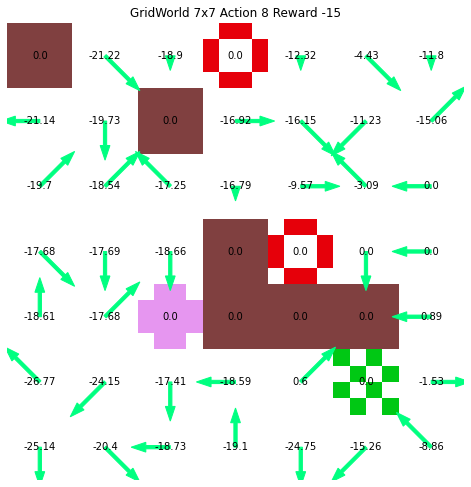

In [22]:
V_MC, _ = nTD(env, pi, 100, 0.1, 10**4)
_, mc_stats = nTD_mod(env, pi, 100, 0.1, 10**4)
env.render(V_MC, pi)

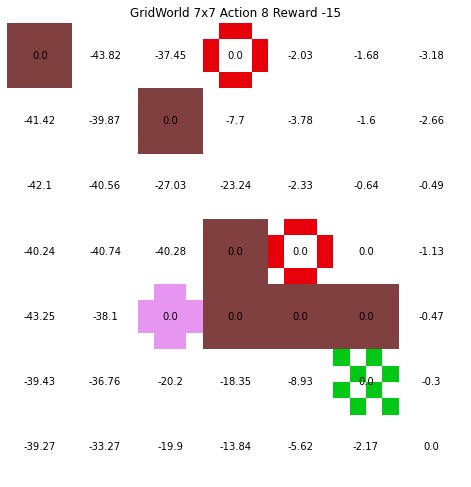

In [23]:
V_td0, _ = nTD(env, pi, 1, 0.1, 10**4)
_, td0_stats = nTD_mod(env, pi, 1, 0.1, 10**4)
env.render(V_td0)

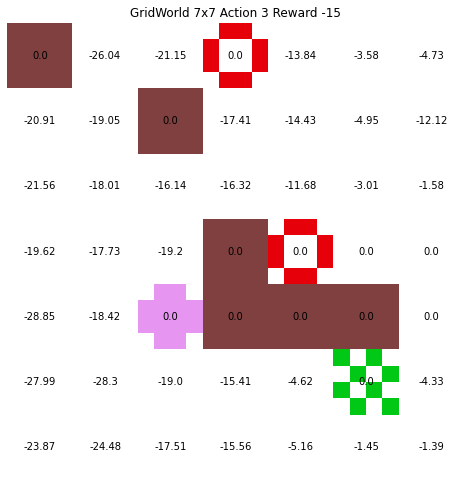

In [24]:
V_td5, _ = nTD(env, pi, 5, 0.1, 10**4)
_, td5_stats = nTD_mod(env, pi, 5, 0.1, 10**4)
env.render(V_td5)

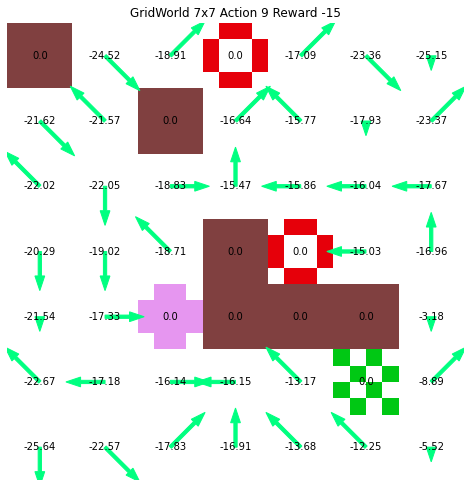

In [25]:
V_pi = policyEvaluation(env, pi, 10**3)
env.render(V_pi, pi)

## Resultados

Para diferenciar el sesgo entre un entorno y otro, se realiza la resta entre el resultado del algoritmo y el valor más cercano a $v_\pi$ que es el resultante de **policyEvaluation** (un método model-based). 

Mientras que para la varianzas se utiliza como tal el resultado de las estadisticas de **nTD_mod**, el cual solamente siguió cada vez la cantidad de la actulización que se realizaría pero sin realizar la actualización para seguir resgistrando la cantidad de estos cambios.

In [26]:
import seaborn as sb
CMAP = "GnBu"

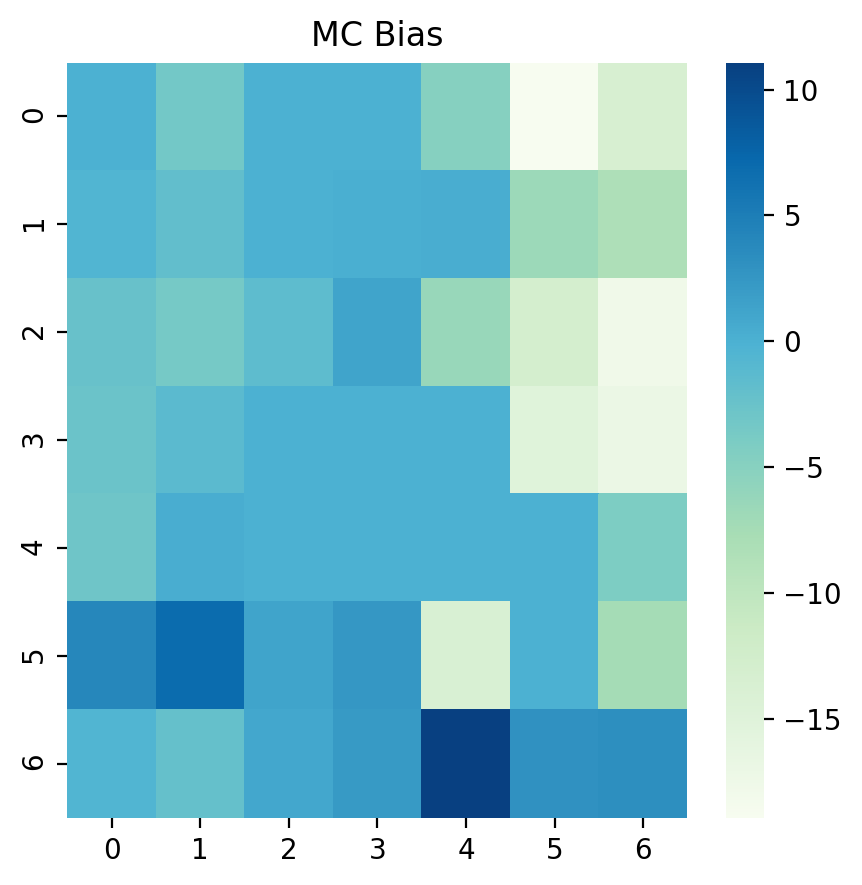

In [27]:
fig, axs = plt.subplots(figsize=(5,5), dpi=200)
heat = sb.heatmap(V_pi - V_MC, cmap=CMAP)
plt.title("MC Bias")
plt.show()

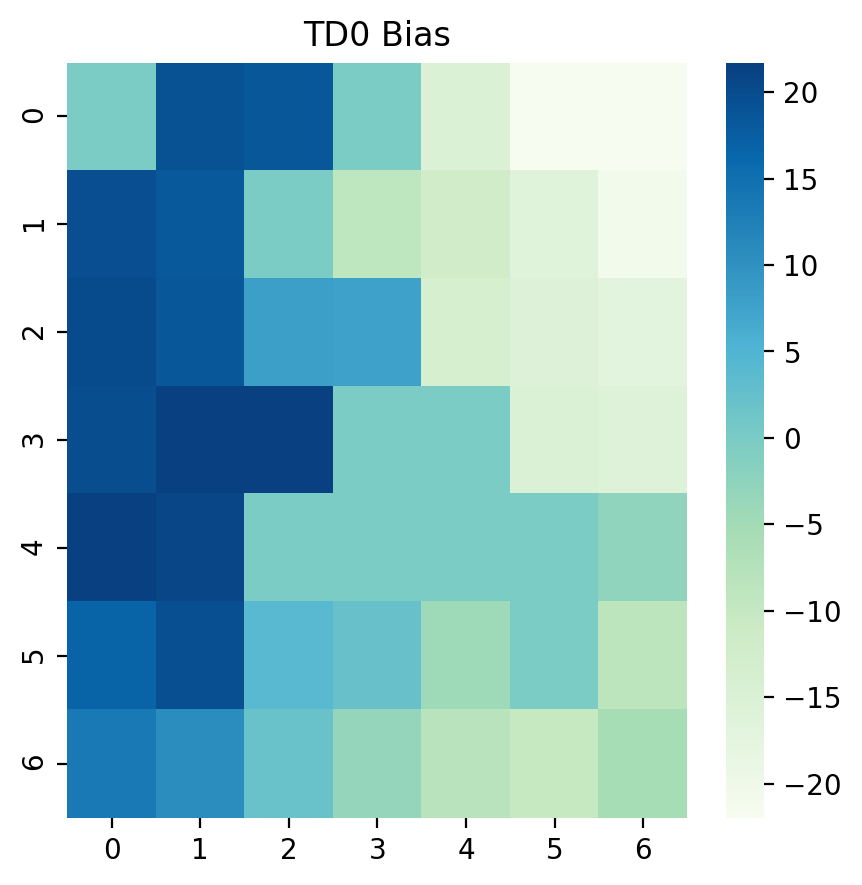

In [28]:
fig, axs = plt.subplots(figsize=(5,5), dpi=200)
heat = sb.heatmap(V_pi - V_td0, cmap=CMAP)
plt.title("TD0 Bias")
plt.show()

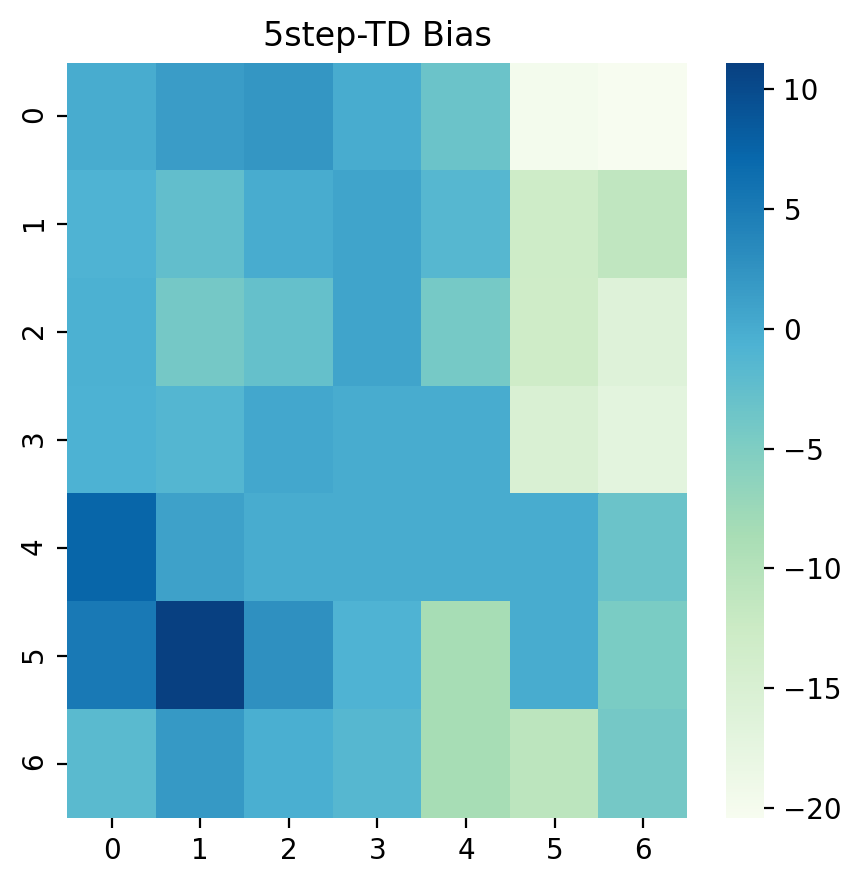

In [29]:
fig, axs = plt.subplots(figsize=(5,5), dpi=200)
heat = sb.heatmap(V_pi - V_td5, cmap=CMAP)
plt.title("5step-TD Bias")
plt.show()

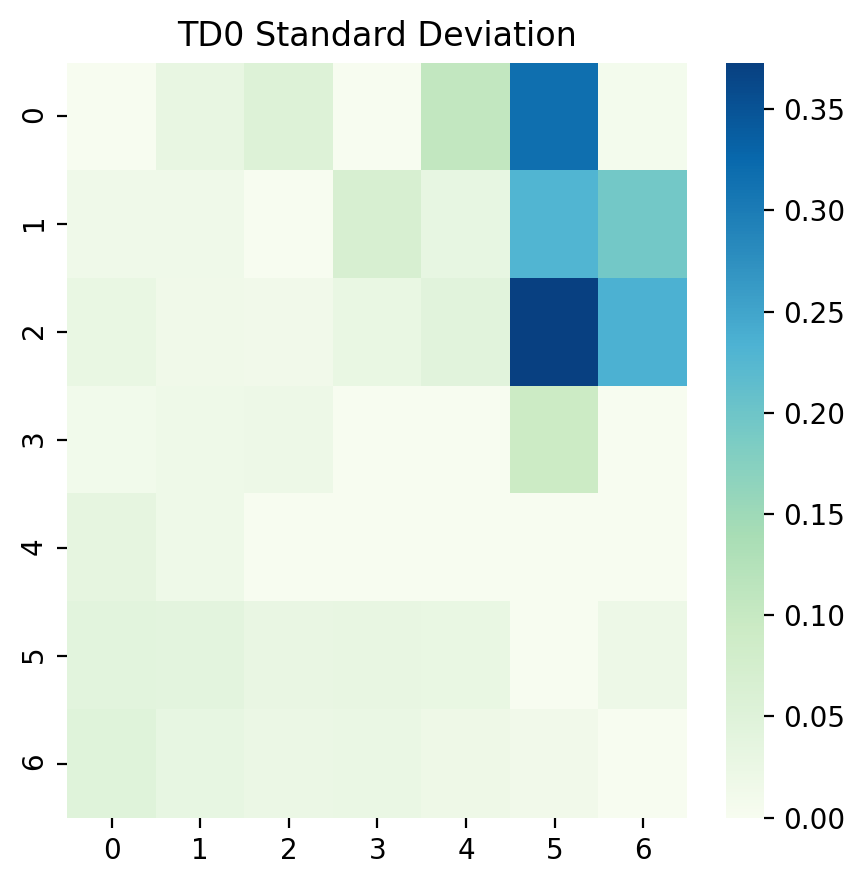

In [30]:
fig, axs = plt.subplots(figsize=(5,5), dpi=200)
heat = sb.heatmap(td0_stats.std, cmap=CMAP)
plt.title("TD0 Standard Deviation")
plt.show()

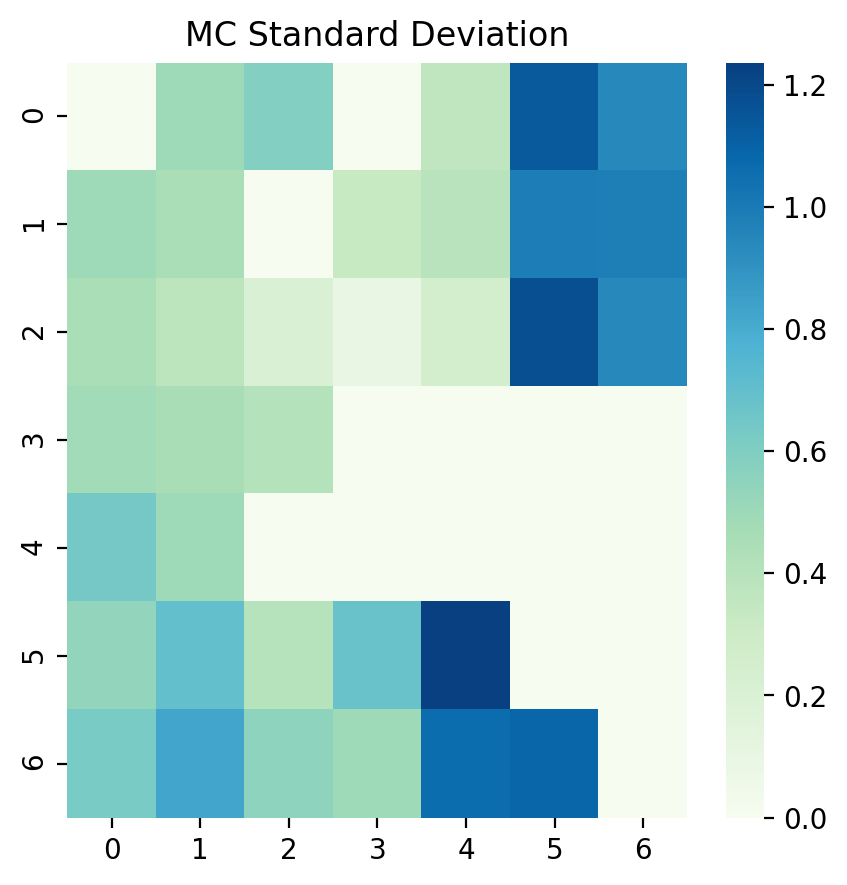

In [31]:
fig, axs = plt.subplots(figsize=(5,5), dpi=200)
heat = sb.heatmap(mc_stats.std, cmap=CMAP)
plt.title("MC Standard Deviation")
plt.show()

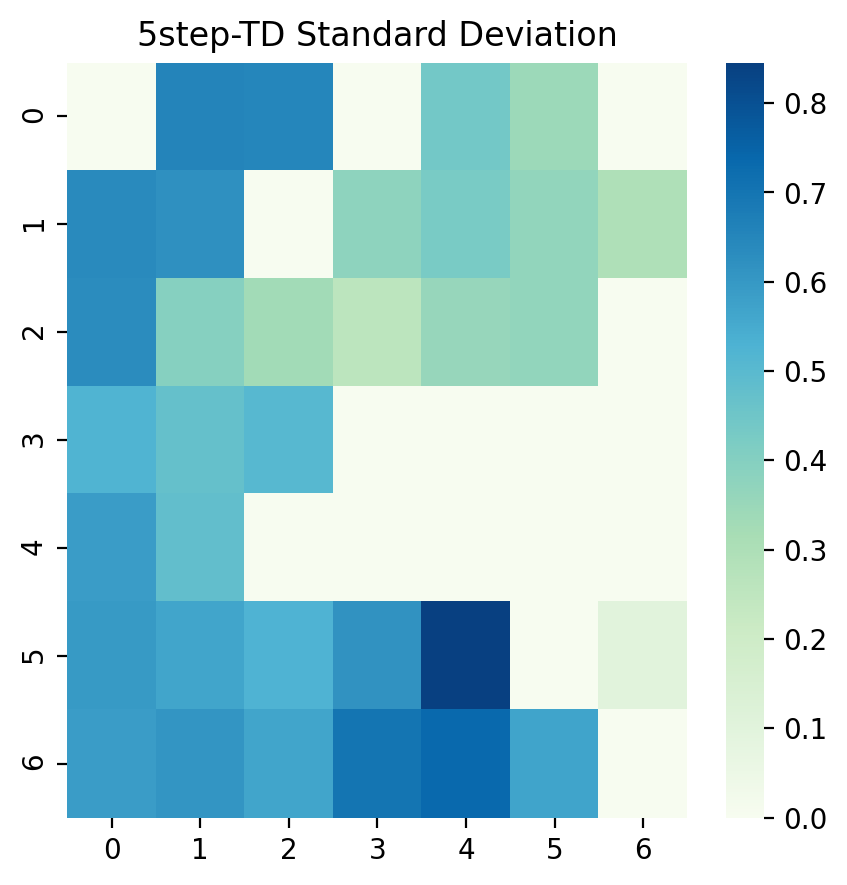

In [32]:
fig, axs = plt.subplots(figsize=(5,5), dpi=200)
heat = sb.heatmap(td5_stats.std, cmap=CMAP)
plt.title("5step-TD Standard Deviation")
plt.show()

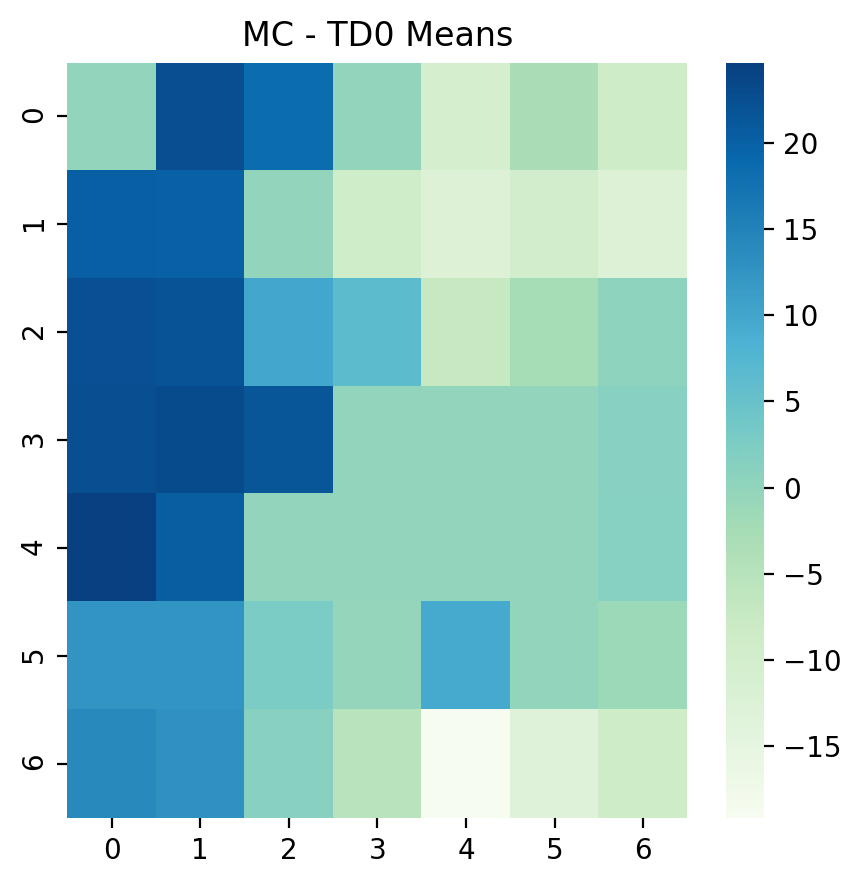

In [33]:
fig, axs = plt.subplots(figsize=(5,5), dpi=200)
heat = sb.heatmap(V_MC - V_td0, cmap=CMAP)
plt.title("MC - TD0 Means")
plt.show()

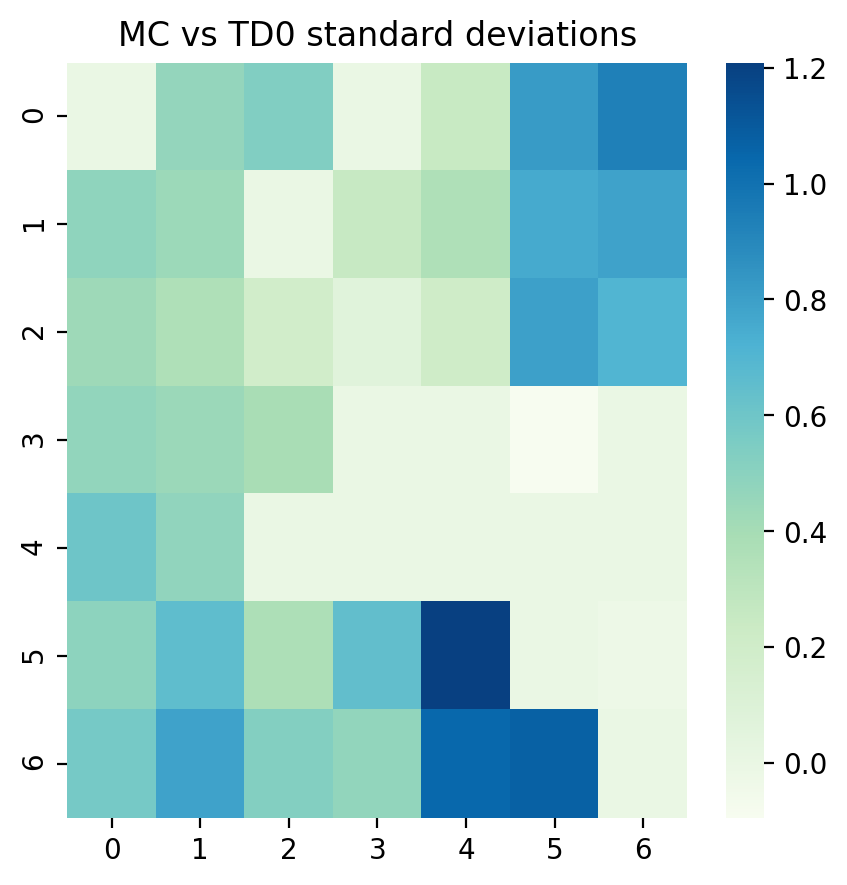

In [34]:
fig, axs = plt.subplots(figsize=(5,5), dpi=200)
heat = sb.heatmap(mc_stats.std - td0_stats.std, cmap=CMAP)
plt.title("MC vs TD0 standard deviations")
plt.show()

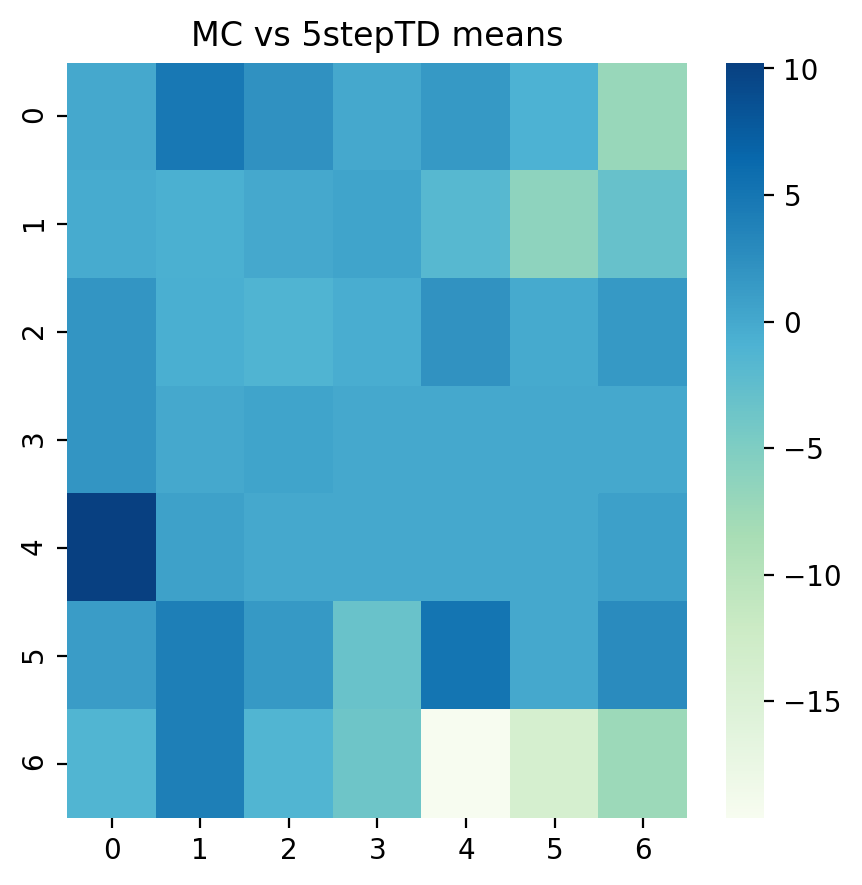

In [35]:
fig, axs = plt.subplots(figsize=(5,5), dpi=200)
heat = sb.heatmap(V_MC - V_td5, cmap=CMAP)
plt.title("MC vs 5stepTD means")
plt.show()

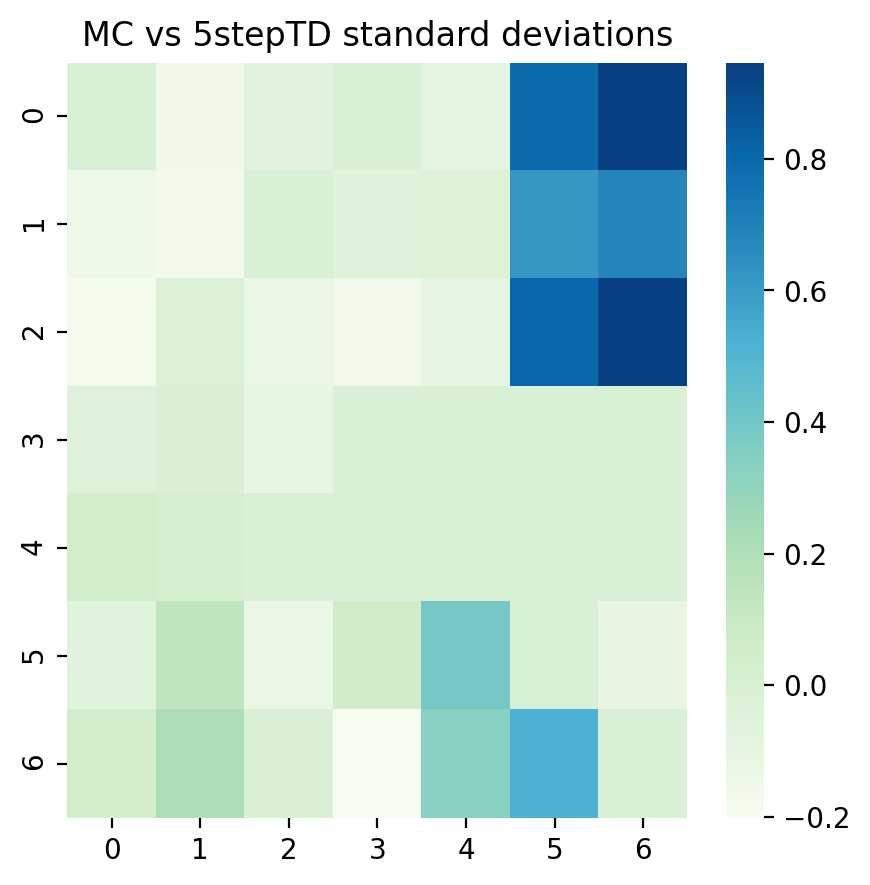

In [36]:
fig, axs = plt.subplots(figsize=(5,5), dpi=200)
heat = sb.heatmap(mc_stats.std - td5_stats.std, cmap=CMAP)
plt.title("MC vs 5stepTD standard deviations")
plt.show()

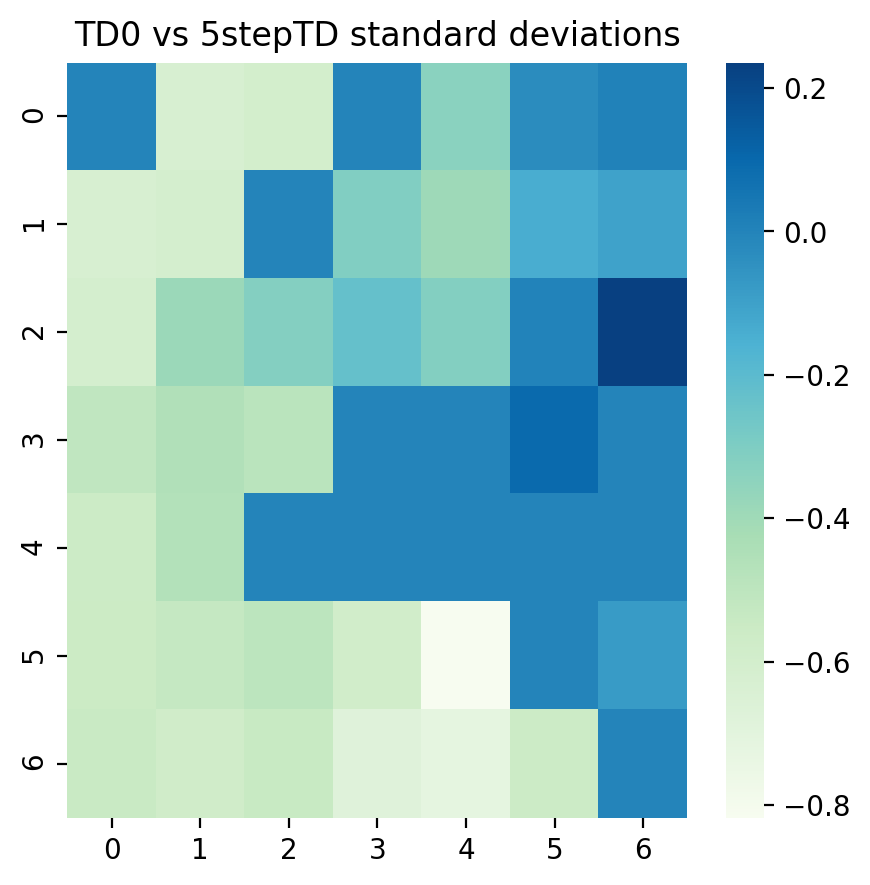

In [37]:
fig, axs = plt.subplots(figsize=(5,5), dpi=200)
heat = sb.heatmap(td0_stats.std - td5_stats.std, cmap=CMAP)
plt.title("TD0 vs 5stepTD standard deviations")
plt.show()